# Introduction: Taxi Fare Prediction

Welcome to another Kaggle challenge. In this contest, the aim is to predict the fare of a taxi ride given the starting time, the starting and ending latitude / longitude, and the number of passengers. This is a __supervised regression__ machine learning task.

In this notebook, I'll provide you with a solid foundation and leave you with the challenge to better the score. Although the dataset is large, this is an approachable problem and as usual with Kaggle competitions, provides realistic practice for building a machine learning solution. The best way to learn is by doing, so let's work through a complete machine learning problem!

Great resources for Kaggle competitions are the [discussion forums](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/discussion) and the [kernels](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/kernels) completed by other data scientists. I recommend using, adapting, and building on others' code, especially when you are getting started.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed 
RSEED = 100

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)

## Read in 5 million rows and examine data

Throughout this notebook, we will work with only 5 million rows (out of 55 million). The first point for improvement might therefore be to use more data!

* __Potential improvement 1: use more data__

Generally, performance of a machine learning model increases as the amount of training data increases. However, there might be diminishing returns, and I sample the data here in order to train faster. The data file is randomly sorted by date, so taking the first 5 million rows is a random sample in terms of time. 

When we read in the data, we tell pandas to treat the `pickup_datetime` as a date. We will also drop the `key` since it is a unique identifier and does not tell us anything about the taxi trip. After reading in the data we'll remove any rows with `nan`  (observations with missing entries). 

In [2]:
data = pd.read_csv('input/train.csv', nrows = 500000, 
                   parse_dates = ['pickup_datetime']).drop(columns = 'key')

# Remove na
data = data.dropna()
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1


### Describe Data

An effective method for catching outliers and anomalies is to find the summary statistics for the data using the `.describe()` method. I like to concentrate on the maxes and the minimums for finding outliers.

In [3]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,499995.000,499995.000,499995.000,499995.000,499995.000,499995.000
mean,11.358,-72.520,39.920,-72.522,39.917,1.683
std,9.916,11.856,8.073,11.797,7.391,1.307
min,-44.900,-2986.242,-3116.285,-3383.297,-2559.749,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,500.000,2140.601,1703.093,40.851,404.617,6.000


Right away we can see there are a number of outliers in the `latitude` and `longitude` columns as well as at least one suspicious entry in the `passenger_count`. The target variable, `fare_amount` seems to have both negative values (unexpected) and extreme values (not so unexpected).

# Data Exploration and Data Cleaning

I often do data exploration and cleaning simulataneously. As I explore the data and find outlying values or errors, I correct them or make a note to follow up later. Data cleaning usually involves domain knowledge (if applicable), statistical descriptions, as well as intuition from working on similar problems. A good place for learning about a problem is the Kaggle discussions boards and other kernels for a competition. 


### Examine the Target Variable

For a first graphical exploration, we can look at the distribution of the `fare_amount`, the target variable we want to train a model to predict. We'll use seaborn's `distplot` which shows both a kernel density estimate plot and a histogram.

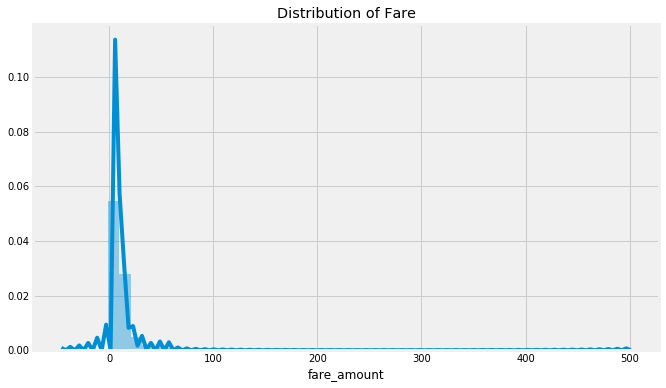

In [4]:
plt.figure(figsize = (10, 6))
sns.distplot(data['fare_amount']);
plt.title('Distribution of Fare');

In [5]:
print(f"There are {len(data[data['fare_amount'] < 0])} negative fares.")
print(f"There are {len(data[data['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(data[data['fare_amount'] > 100])} fares greater than $100.")

There are 21 negative fares.
There are 14 $0 fares.
There are 214 fares greater than $100.


### Remove Outliers

Based on [this discussion](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/discussion/63319) on [real-world taxi fares in New York City](http://nymag.com/nymetro/urban/features/taxi/n_20286/), I'm going to remove any fares less than $2.50. This appears to be the minimum fare, so any values in the training set less than this amount must be errors in data collection or entry.

Ill also remove any fares greater than $100. I'll justify this based on the limited number of fares outside this bounds, but it might be possible that including these values helps the model! I'd encourage you to try different values and see which works best.

In [6]:
data = data[data['fare_amount'].between(left = 2.5, right = 100)]

For visualization purposes, I'll create a binned version of the fare. This divides the variable into a number of bins, turning a continuous variable into a discrete, categorical variable.

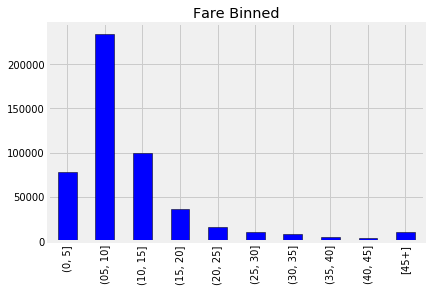

In [7]:
# Bin the fare and convert to string
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
data.loc[data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

### Empirical Cumulative Distribution Function Plot

Another plot for showing the distribution of a single variable is the [empirical cumulative distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function). This shows the percentile on the y-axis and the variable on the x-axis and gets around some of the issues associated with binning data for histograms or the kernel width of the KDE.


In [8]:
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

Below is an example of the ecdf. This plot is good for viewing outliers and also the percentiles of a distribution.

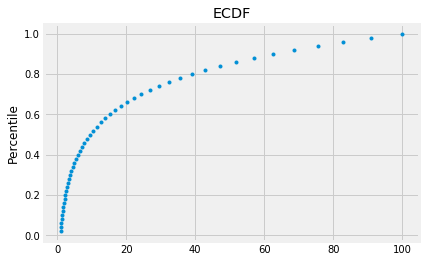

In [9]:
xs, ys = ecdf(np.logspace(0, 2))
plt.plot(xs, ys, '.');
plt.ylabel('Percentile'); plt.title('ECDF');

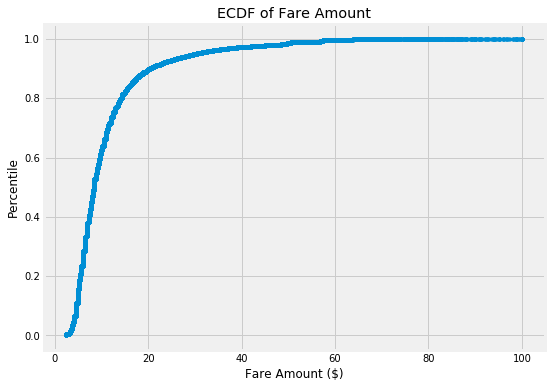

In [10]:
xs, ys = ecdf(data['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');

This shows the distribution is heavily right skewed. Most of the fares are below \$20, with a heavy right tail of larger fares.

#### Other Outliers

We can also remove observations based on outliers in other columns. First we'll make a graph of the passenger counts which seemed to have some suspicious values.

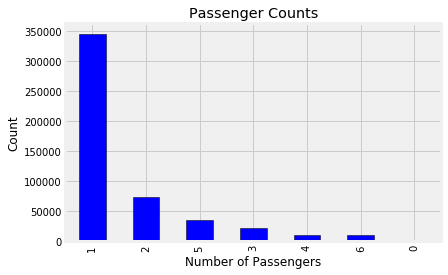

In [11]:
data['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

Based on this graph, we'll remove any passenger counts greater than 6.

In [12]:
data = data.loc[data['passenger_count'] < 6]

For the `latitude` and `longitude` columns, we can use statistics as well as our intuition for removing outliers. Here I'll find the 2.5% and 97.5% percentile values in each column and keep only measurements close to that range. 

In [13]:
print(f'Initial Observations: {data.shape[0]}')

Initial Observations: 489152


In [14]:
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print(f'{col.capitalize():17}: 2.5% = {round(np.percentile(data[col], 2.5), 2):5} \t 97.5% = {round(np.percentile(data[col], 97.5), 2)}')

Pickup_latitude  : 2.5% = 40.64 	 97.5% = 40.8
Pickup_longitude : 2.5% = -74.01 	 97.5% = -73.78
Dropoff_latitude : 2.5% = 40.64 	 97.5% = 40.81
Dropoff_longitude: 2.5% = -74.01 	 97.5% = -73.78


Based on these values, we can remove outliers. This is somewhat based on intuition and there might be a more accurate process for carrying out this operation! Here is another potential point for improvement:

* __Potential improvement 2: experiment with different methods to remove outliers.__ This could be through domain knowledge (such as using a map) or it could be using more rigorous statistical methods (such as z-scores).

In [15]:
# Remove latitude and longtiude outliers
data = data.loc[data['pickup_latitude'].between(40, 42)]
data = data.loc[data['pickup_longitude'].between(-75, -72)]
data = data.loc[data['dropoff_latitude'].between(40, 42)]
data = data.loc[data['dropoff_longitude'].between(-75, -72)]

print(f'New number of observations: {data.shape[0]}')

New number of observations: 478964


Now we can graph the `latitude` and `longitude` columns to see the distribution. We'll just sample 10000 values so the plot doesn't take too long to generate.

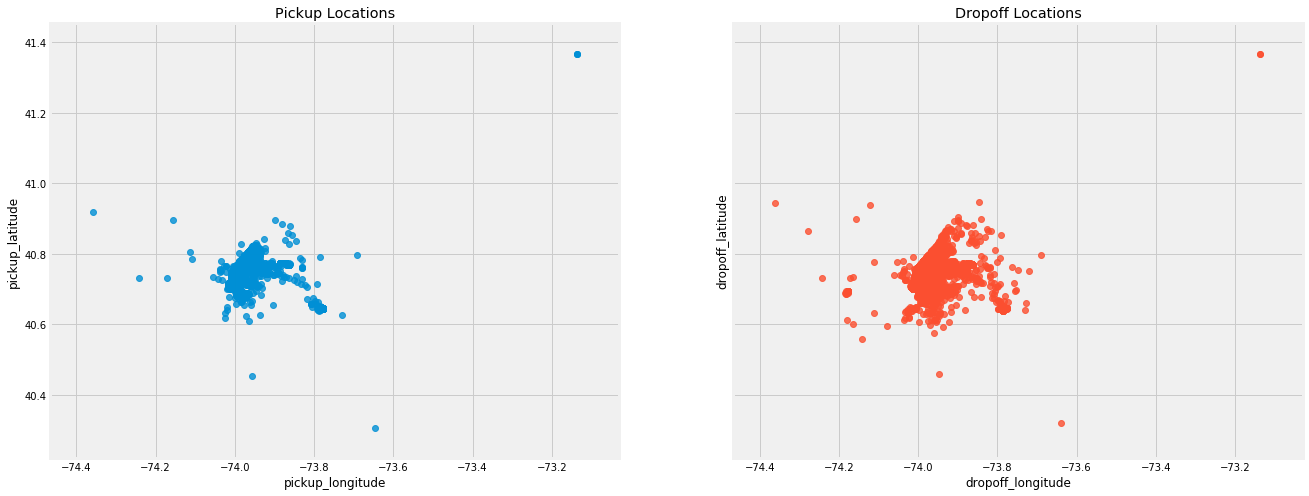

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[0]);
sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

### Rides on Map of NYC

For a more contextualized representation, we can plot the pickup and dropoff on top of a map of New York. The following code is taken directly from https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration by Kaggle user [breeman](https://www.kaggle.com/breemen). All credit goes to him and please check out the rest of his kernel for more excellent work! 

The map was extracted from OpenStreetMaps (https://www.openstreetmap.org/export#map=12/40.7250/-73.8999)

In [17]:
# load image of NYC map
# BB = (-74.5, -72.8, 40.5, 41.8)
# nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.1, -73.7, 40.6, 40.85)
nyc_map_zoom = plt.imread('https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/images/nyc_-74.1_-73.7_40.6_40.85.PNG?raw=true')

In [18]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(1, 2, figsize=(18, 22))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].axis('off')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].axis('off')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    
# plot training data on map zoomed in
plot_on_map(data.sample(1_000_000, random_state = RSEED), BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)

ValueError: Cannot take a larger sample than population when 'replace=False'

Most of the rides are concentrated in Manhattan and it looks like there are more rides ending outside Manhattan than inside. I'm not sure we'll be able to use this for modeling though.

To see if there is a difference in locations based on the fare, we map each fare bin to a different color and then plot.

In [19]:
# Create a color mapping based on fare bins
color_mapping = {fare_bin: palette[i] for i, fare_bin in enumerate(data['fare-bin'].unique())}
color_mapping

{'(0, 5]': (0.65098039215686276, 0.80784313725490198, 0.8901960784313725),
 '(15, 20]': (0.12156862745098039, 0.47058823529411764, 0.70588235294117652),
 '(05, 10]': (0.69803921568627447, 0.87450980392156863, 0.54117647058823526),
 '(10, 15]': (0.20000000000000001, 0.62745098039215685, 0.17254901960784313),
 '(20, 25]': (0.98431372549019602, 0.60392156862745094, 0.59999999999999998),
 '(30, 35]': (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 '[45+]': (0.99215686274509807, 0.74901960784313726, 0.43529411764705883),
 '(25, 30]': (1.0, 0.49803921568627452, 0.0),
 '(35, 40]': (0.792156862745098, 0.69803921568627447, 0.83921568627450982),
 '(40, 45]': (0.41568627450980394, 0.23921568627450981, 0.60392156862745094)}

The `map` function will replace the values in a column with the corresponding values in the dictionary. It matches the column values to the keys in the dictionary and then replaces the values with the dictionary values.

In [20]:
data['color'] = data['fare-bin'].map(color_mapping)
plot_data = data.sample(1_000_000, random_state = RSEED)

ValueError: Cannot take a larger sample than population when 'replace=False'

We'll plot the pickup and dropoff separately to see the difference.

In [ ]:
BB = BB_zoom

fig, axs = plt.subplots(1, 1, figsize=(20, 18))

# Plot the pickups
for b, df in plot_data.groupby('fare-bin'):
    # Set the zorder to 1 to plot on top of map
    axs.scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Pickup locations', size = 32)
    axs.axis('off')
    
# Legend
leg = axs.legend(fontsize = 28, markerscale = 3)

# Adjust alpha of legend markers
for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Fare Bin', prop = {'size': 28})

# Show map in background (zorder = 0)
axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 18))

# Plot the pickups
for b, df in plot_data.groupby('fare-bin'):
    axs.scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, 
                alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Dropoff locations', size = 32)
    axs.axis('off')
    
# Legend
leg = axs.legend(fontsize = 28, markerscale = 3)

# Adjust alpha of legend markers
for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Fare Bin', prop = {'size': 28})

# Show map in background (zorder = 0)
axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

The most expensive rides tend to cluster around the airpot (seen at lower right). If we look at the [relevant literate](http://nymag.com/nymetro/urban/features/taxi/n_20286/) we read that the standard fare for trips to John F Kennedy Airpot is \$45. If we knew _for sure_ that a flight was bound for the airport, then we would know the fare! Perhaps this is another area for improvement, if we can somehow match the pickups / destinations to the airport using the coordinates. 

# Feature Engineering

Feature engineering is the process of creating features - predictor variables - out of a dataset. __Feature engineering is the most important step of the machine learning pipeline ([A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)).__ A model can only learn from the features it is given, and properly constructing features will determine how well your model performs.

Feature engineering involves domain expertise and experience on prior machine learning projects. A good place to start for Kaggle competitions is other kernels. Feel free to use, adapt, and build on other's work! 

### Relative Distances in Latitude and Longitude

As a simple first step of feature engineering, we can find the absolute value of the difference in latitude and longitude between the `pickup` and `dropoff`. While this does not represent an actual distance (we would have to convert coordinate systems), it can be used as a relative comparison of the distances of taxi rides. As the cost of a taxi ride is proportional to duration or distance, we would expect the relative distances to be a useful measure for estimating the fare. 

In [21]:
# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

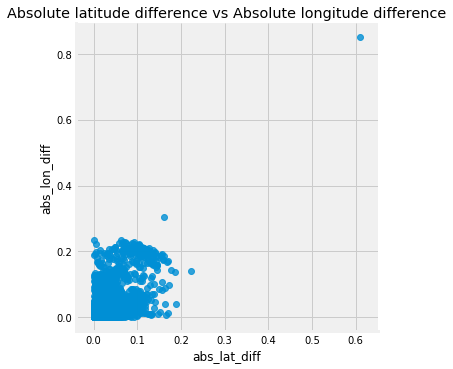

In [22]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False,
           data = data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

There do seem to be a few outliers, but I'll leave those in for now. We might also want to take a look if there are any observations where both the absolute differences are 0.

In [23]:
no_diff = data[(data['abs_lat_diff'] == 0) & (data['abs_lon_diff'] == 0)]
no_diff.shape

(5132, 11)

It looks like there are 51,000 rides where the absolute latitude and longitude does not change! That seems a little strange. This might be a point worth following up! 

Let's remake the plot above colored by the fare bin.

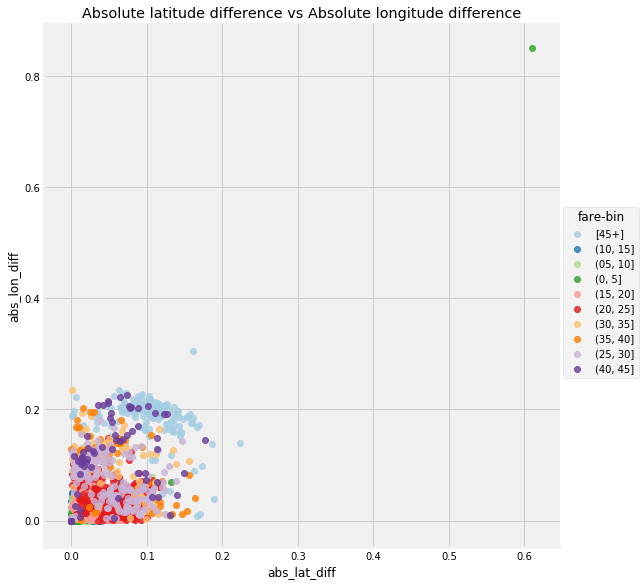

In [24]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8, palette=palette,
           fit_reg = False, data = data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

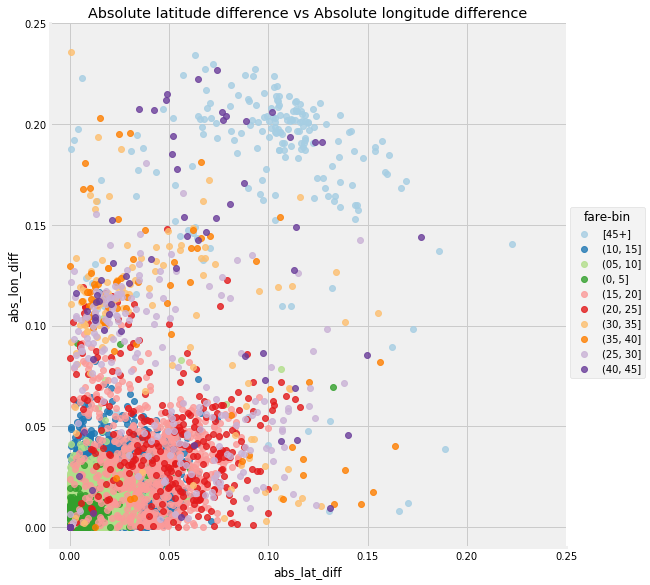

In [25]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8, palette = palette,
           fit_reg = False, data = data.sample(10000, random_state=RSEED));

plt.xlim((-0.01, .25)); plt.ylim((-0.01, .25))
plt.title('Absolute latitude difference vs Absolute longitude difference');

It does seem that the rides with a larger absolute difference in both longitude and latitude tend to cost more. To capture both differences in a single variable, we can add up the two differences in latitude and longitude and also find the square root of the sum of differences squared. The former feature would be called the Manhattan distance - or l1 norm - and the latter is called the Euclidean distance - or l2 norm. Both of these distances are specific examples of the general Minkowski distance.

## Manhattan and Euclidean Distance

The [Minkowski Distance](https://en.wikipedia.org/wiki/Minkowski_distance) between two points is expressed as:

$${\displaystyle D\left(X,Y\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{1/p}}$$

if p = 1, then this is the Manhattan distance and if p = 2 this is the Euclidean distance. You may also see these referred to as the l1 or l2 norm where the number indicates p in the equation. 

I should point out that these equations are only valid for actual distances in a [cartesian coordinate system](https://en.wikipedia.org/wiki/Cartesian_coordinate_system) and here we only use them to find relative distances. To find the actual distances in terms of kilometers, we have to work with the latitude and longitude [geographical coordinate system](https://en.wikipedia.org/wiki/Geographic_coordinate_system). This will be done later using the Haversine formula.

In [26]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

Here's an example of the Manhattan Distance which is simply the sum of differences in each dimension.

In [27]:
minkowski_distance(0, 3, 0, 4, 1)

7.0

Here's the same as a Euclidean distance which is the length of a straight line connecting the points.

In [28]:
minkowski_distance(0, 3, 0, 4, 2)

5.0

Let's apply this function to the latitude and longitudes. Again, this does not represent an absolute distance because we would need to convert coordinate systems. However, these features are useful as _relative_ comparisons between rides.

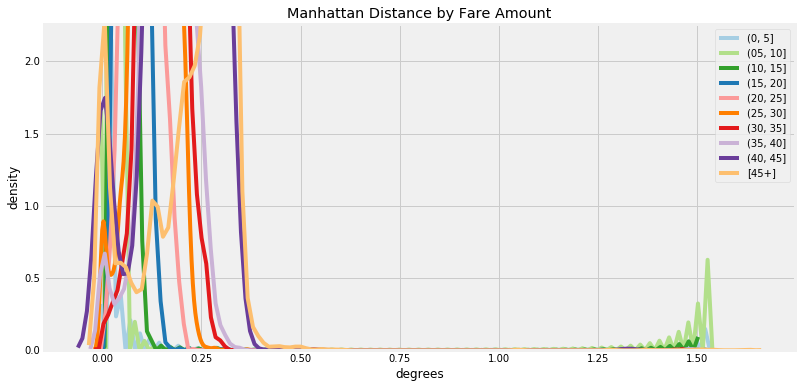

In [29]:
data['manhattan'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 1)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['manhattan'], label = f'{f}', color = list(grouped['color'])[0]);

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Manhattan Distance by Fare Amount');

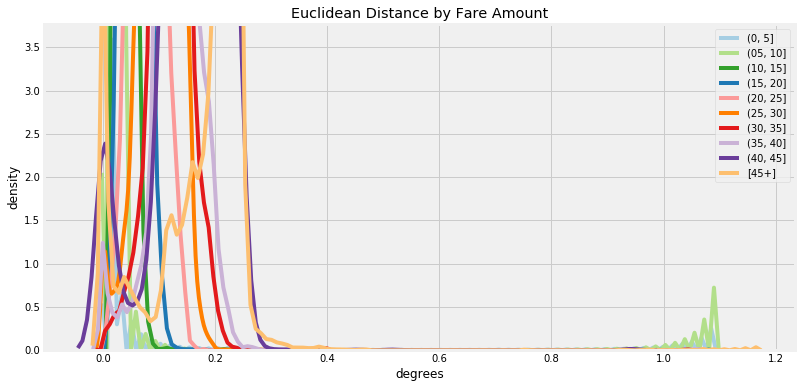

In [30]:
data['euclidean'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 2)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['euclidean'], label = f'{f}', color = list(grouped['color'])[0]);

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Euclidean Distance by Fare Amount');

These features do seem to have some differences between the different fare amounts, so they might be helpful in predicting the fare. 

In [31]:
data.groupby('fare-bin')['euclidean'].agg(['mean', 'count'])

,mean,count
fare-bin,,
"(0, 5]",0.009,74718
"(05, 10]",0.020,225172
"(10, 15]",0.037,95237
"(15, 20]",0.055,35000
"(20, 25]",0.076,15206
"(25, 30]",0.100,9535
"(30, 35]",0.117,7114
"(35, 40]",0.127,4042
"(40, 45]",0.153,3403


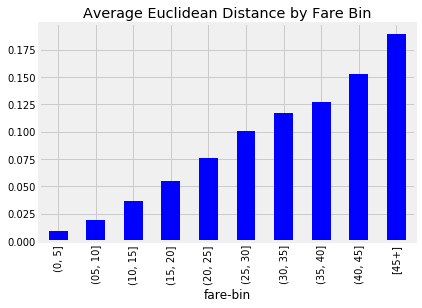

In [32]:
data.groupby('fare-bin')['euclidean'].mean().plot.bar(color = 'b');
plt.title('Average Euclidean Distance by Fare Bin');

There is a very clearly relationship between the fare bin and the average distance of the trip! This should give us confidence that this feature will be useful to a model.

Another plot we can make is the passenger count distribution colored by the fare bin.

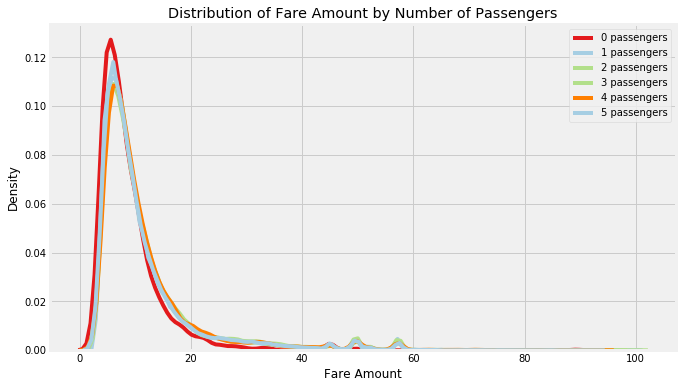

In [33]:
plt.figure(figsize = (10, 6))

for p, grouped in data.groupby('passenger_count'):
    sns.kdeplot(grouped['fare_amount'], label = f'{p} passengers', color = list(grouped['color'])[0]);
    
plt.xlabel('Fare Amount'); plt.ylabel('Density')
plt.title('Distribution of Fare Amount by Number of Passengers');

There does not appear to be much difference between the number of passengers. To get a more accurate picture, we can calculate the actual stats.

In [34]:
data.groupby('passenger_count')['fare_amount'].agg(['mean', 'count'])

,mean,count
passenger_count,,
0,8.942,1754
1,11.153,338450
2,11.774,72467
3,11.450,21324
4,11.663,10374
5,11.204,34595


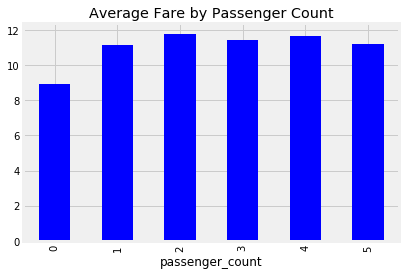

In [35]:
data.groupby('passenger_count')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by Passenger Count');

There is a small but noticeable difference in the average fare by the number of passengers.

## Read in test data and create same features

Before we forget, we need to read in the test data and create the same features. The test data must have the same exact features as the training data used in the model. 

We can't exclude any of the test data based on outliers, and we also shouldn't use the test data for filtering outliers in the training data. The test data should ideally only be used a single time, to test the performance of a trained model.

For the test data, we need to save the `key` column for making submissions. 

In [36]:
test = pd.read_csv('input/test.csv', parse_dates = ['pickup_datetime'])

# Create absolute differences
test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

# Save the id for submission
test_id = list(test.pop('key'))

test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff
count,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000
mean,-73.975,40.751,-73.974,40.752,1.671,0.022,0.023
std,0.043,0.034,0.039,0.035,1.279,0.026,0.037
min,-74.252,40.573,-74.263,40.569,1.000,0.000,0.000
25%,-73.993,40.736,-73.991,40.735,1.000,0.007,0.006
50%,-73.982,40.753,-73.980,40.754,1.000,0.015,0.013
75%,-73.968,40.767,-73.964,40.769,2.000,0.028,0.025
max,-72.987,41.710,-72.991,41.697,6.000,0.633,0.849


No fare information here! It's our job to predict the fare for each test ride.

In [37]:
test['manhattan'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 1)

test['euclidean'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 2)

# Calculate Distance between points using Haversine distance

To calculate a more realistic distance between the pickup and dropoff, we can use the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). This is the Great Circle distance, representing the shortest distance along the surface of the Earth connecting two points taking into account the fact that the Earth is a sphere (or so I'm told). It's not the best measure because the taxis do not travel along lines, but it's more accurate in terms of an absolute distance than the Manhattan and Euclidean distances made from the absolute latitude and longitude difference. The Manhattan and Euclidean distances are relative and do not take into account the spherical shape of the Earth. 

(We could convert the latitude and longitude into cartesian coordinates after establishing an origin. One option would be to use the center of the Earth and another would be to use the average of all coordinates in the data as an origin. Then, once we converted the points in this coordinate system, we could use the Manhattan and Euclidean formulas to find distances between points in kilometers. These are all approximations because we can't find the actual street distance.)

The formula for Haversine distance is:

$${\displaystyle =2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\cos(\varphi _{2})\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$$

where r is the radius of the Earth. The end units will be in km. My thanks go to this Stack Overflow answer: https://stackoverflow.com/a/29546836

In [38]:
# Radius of the earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [39]:
data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

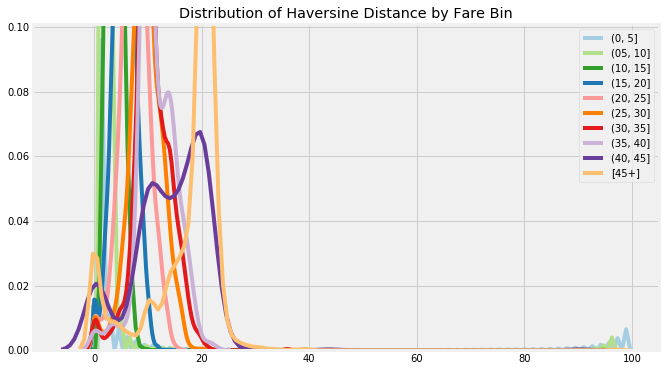

In [40]:
subset = data.sample(100000, random_state=RSEED)

plt.figure(figsize = (10, 6))

for f, grouped in subset.groupby('fare-bin'):
    sns.kdeplot(grouped['haversine'], label = f'{f}', color = list(grouped['color'])[0]);
    
plt.title('Distribution of Haversine Distance by Fare Bin');

It does seem there is a significant difference here! The larger haversine distances tend to have larger fares as expected. The differences seem to be close to those returned from the Euclidean and Manhattan calculations.

In [41]:
data.groupby('fare-bin')['haversine'].agg(['mean', 'count'])

,mean,count
fare-bin,,
"(0, 5]",0.925,74718
"(05, 10]",1.938,225172
"(10, 15]",3.704,95237
"(15, 20]",5.578,35000
"(20, 25]",7.522,15206
"(25, 30]",9.486,9535
"(30, 35]",10.728,7114
"(35, 40]",11.532,4042
"(40, 45]",13.924,3403


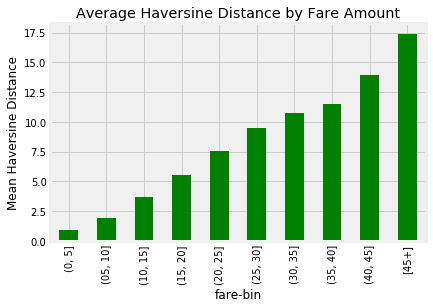

In [42]:
data.groupby('fare-bin')['haversine'].mean().sort_index().plot.bar(color = 'g');
plt.title('Average Haversine Distance by Fare Amount');
plt.ylabel('Mean Haversine Distance');

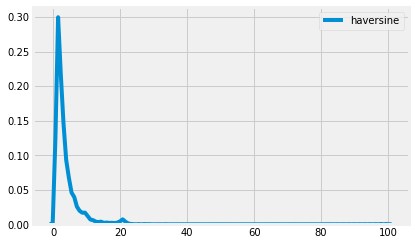

In [43]:
sns.kdeplot(test['haversine']);

The test distribution seems to be similar to the training distribution.

As a final step, we can find the correlations between distances and fares.

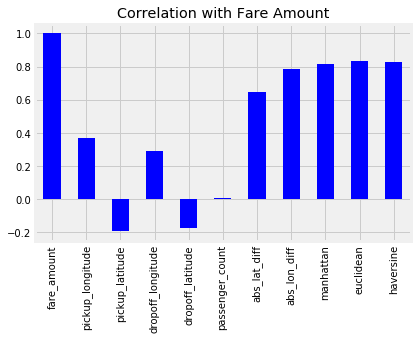

In [44]:
corrs = data.corr()
corrs['fare_amount'].plot.bar(color = 'b');
plt.title('Correlation with Fare Amount');

All the measures of distance have a _positive_ linear correlation with the fare, indicating that as they increase, the fare tends to increase as well. 

The correlation coefficient measures the strength and direction of a linear relationship. Because the linear relationship with the target variable is so strong, we may be able to just use a linear model (regression) to accurately predict the fares. 

# Machine Learning

Now that we have built a few potentially useful features, we can use them for machine learning: training an algorithm to predict the target from the features. We'll start off with a basic model - Linear Regression - only using a few features and then move on to a more complex models and more features. There is reason to believe that for this problem, even a simple linear model will perform well because of the strong linear correlation of the distances with the fare. We generally want to use the simplest - and hence most interpretable - model that is above an accuracy threshold (dependent on the application) so if a linear model does the job, there's no need to use a highly complex ensemble model. It's a best practice to start out with a simple model for just this reason! 


## First Model: Linear Regression

The first model we'll make is a simple linear regression using 3 features: the `abs_lat_diff`, `abs_lon_diff`, and `passenger_count`. This is meant to serve as a baseline for us to beat.

It's good to start with a simple model because it will give you a baseline. Also, if a simple model works well enough, then there may be no need for more complex models. If a linear regression will get the job done, then you don't need a neural network!

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

## Create Training and Validation Set

We'll want to create a training and separate validation set to assess our model. Ideally, we only use the test set once, to evaluate the final model. We can make a validation set with 1 million observations to estimate our performance.

We __stratify__ the split using the `fare-bin`. This ensures that the training and validation set have the same distribution of fare bins. This is important for imbalanced classification problems, but it can also be useful for regression problems so we don't end up with a lot of outliers in terms of the target in either the validation or training set. (We have to stratify based on a discrete variable which is why we use the fare bin.)

In [47]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 100000)

### Train with Simple Features

We'll train the linear regression using three features. The benefit of the linear regression is that it's interpretable: we can inspect the coefficients and intercept.

In [48]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      '\tabs_lon_diff coef:', round(lr.coef_[1], 4),
      '\tpassenger_count coef:', round(lr.coef_[2], 4))

Intercept 5.0875
abs_lat_diff coef:  113.7327 	abs_lon_diff coef: 163.5308 	passenger_count coef: 0.0214


In all cases, the coefficient is positive, indicating a larger value of the variable corresponds to a larger fare according to the model. We can say that according to a linear model, for every 1 more passenger, the fare increases by \$0.02. The `intercept` indicates the fare that would be predicted if there is no latitude or longitude difference and the passenger count is 0.

#### Score Model

Here we use the validation set for assessing the model. We'll use two metrics:

* __Root mean squared error__: the metric used by the competition
* __Mean absolute percentage error__: the average percentage error of the predictions

I like using the mean absolute percentage error (MAPE) because it's often more interpretable. 

In [49]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [50]:
evaluate(lr, ['abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.36 	 mape = 28.26
Validation: rmse = 5.39 	 mape = 28.39


Without anything to compare these results to, we can't say if they are good. This is the reason for establishing a basic baseline with no machine learning!

### Naive Baseline

To make sure that machine learning is even applicable to the task, we should compare these predictions to a naive guess. For a regression task, this can be as simple as the average value of the target in the training data.

In [51]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 9.33 	 mape = 64.82
Baseline Validation: rmse = 9.38 	 mape = 64.91


According to the naive baseline, our machine learning solution is effective! We are able to reduce the percentage error by about half and generate much better predictions than using no machine learning. This should give us confidence we are on the right track.

### Make a submission

In order to make a submission to Kaggle, we have to make predictions on the test data. Below we make the predictions and save them to a csv file in the format specified by the competition

In [52]:
preds = lr.predict(test[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_lr_simple.csv', index = False)

As a sanity check, we can plot the predictions.

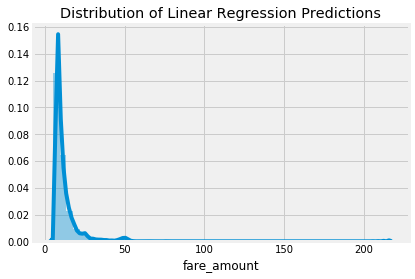

In [53]:
sns.distplot(sub['fare_amount'])
plt.title('Distribution of Linear Regression Predictions');

The predicted distribution appears reasonable. Because the competition uses root mean squared error as the metric, any predictions that are far off will have an outsized effect on the error. Let's look at predictions that were greater than \$100.

In [54]:
test.loc[sub[sub['fare_amount'] > 100].index]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,euclidean,haversine
4080,2010-06-11 13:37:21,-73.137,41.366,-73.984,40.733,1,0.633,0.847,1.480,1.057,100.106
5887,2010-07-04 16:44:11,-73.137,41.366,-73.983,40.767,1,0.599,0.845,1.444,1.036,97.348
8529,2009-11-25 19:32:52,-73.137,41.366,-73.987,40.758,3,0.608,0.849,1.457,1.044,98.300


In [55]:
sub[sub['fare_amount'] > 100]

,key,fare_amount
4080,2010-06-11 13:37:21.0000004,215.596
5887,2010-07-04 16:44:11.0000002,211.445
8529,2009-11-25 19:32:52.0000001,213.186


These three predictions that are all over \$100 don't appear to be completely unexpected given the large `abs_lat_diff` and `abs_lon_diff`. We'll have to take a look at these predictions for other models and see if they agree. 

In [56]:
simple_over_100 = list(sub[sub['fare_amount'] > 100].index)
sub['fare_amount'].describe()

count   9914.000
mean      11.459
std        8.097
min        5.109
25%        7.452
50%        9.081
75%       12.327
max      215.596
Name: fare_amount, dtype: float64

As a linear model, the linear regression is not flexible at all. In other words, it has a high bias because it assumes a linear relationship between the predictor variables (features) and the response (target). The final formula produced by the model is interpretable, but that doesn't mean it's right! In machine learning, we often have to make a tradeoff between model interpretability and model accuracy. In this case the linear regression does well, but as we'll see, a more complex model does even better.

## Use More Features

While the first model scored well relative to the baseline, there is much room for improvement. As a first step, let's use one of the other features we created, the `haversine` distance.

In [57]:
lr.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

evaluate(lr, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.04 	 mape = 24.76
Validation: rmse = 5.08 	 mape = 24.86


In [58]:
print(lr.intercept_)
print(lr.coef_)

4.56444080301
[  4.29996770e+00  -2.43728557e+02  -1.07321964e+02   1.56697329e-02]


Using this one more feature improved our score slightly. Here's another chance for improvement using the same model:

* __Potential Improvement 3: find an optimal set of features or construct more features__. This can involve [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) or trying different combinations of features and evaluating them on the validation data. You can build additional features by looking at others' work or researching the problem.

#### Collinear Features

One thing we do want to be careful about is highly correlated, known as [collinear](https://en.wikipedia.org/wiki/Multicollinearity), features. These can decrease the generalization performance of the model and lead to less interpretable models. Many of our features are already highly correlated as shown in the heatmap below. This plots the Pearson Correlation Coefficient for each pair of variables.

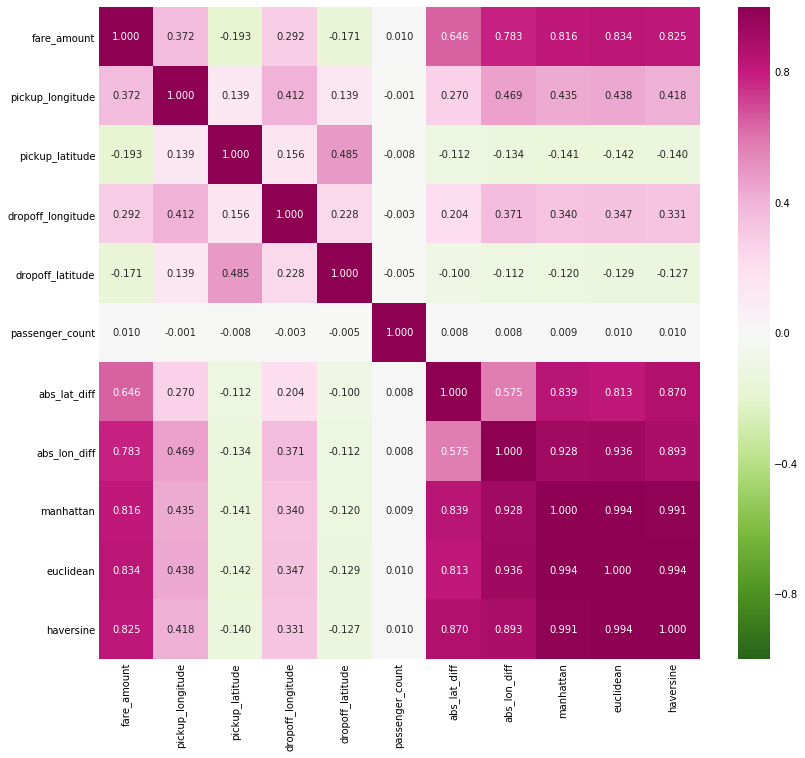

In [59]:
corrs = data.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

You might not want to use two variables that are very highly correlated with each other (such as `euclidean` and `haversine`) because of issues with interpretability and performance.

# Upgraded Model

When we want to improve performance, we generally have a few options:

1. Get more data - either more observations or more variables
2. Engineer more / better features
3. Perform feature selection to remove irrelevant features
4. Try a more complex model
5. Perform hyperparameter tuning of the selected model

We already saw that including another feature could improve perfomance. For now let's move past the features and focus on the model (we'll come back to features later).

The simple linear regression has no hyperparameters to optimize (no settings to tune) so we'll try approach 4. If the more complex model does well, we can use it for testing additional features or performing feature selection

## Non-Linear Model: Random Forest

For a first non-linear model, we'll use the [Random Forest](https://medium.com/p/77bf308a9b76?source=user_profile---------3------------------) regressor. This is a powerful ensemble of regression trees that has good performance and generalization ability because of its low variance. We'll use most of the default hyperparameters but change the `n_estimators` and the `max_depth` of each tree in the forest. For the features, we'll use the four features which delivered good performance in the linear regression.

In [60]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.4s finished
/Users/nkreiling/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=True, random_state=None,
           verbose=1, warm_start=False)

In [61]:
evaluate(random_forest, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.0s finished


Training:   rmse = 2.91 	 mape = 17.73
Validation: rmse = 4.37 	 mape = 22.82


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.3s finished


The random forest does much better than the simple linear regression. This indicates that the problem is not completely linear, or at least is not linear in terms of the features we have constructed. From here going forward, we'll use the same random forest model because of the increased performance. 

#### Overfitting

Given the gap between the training and the validation score, we can see that our model is __overfitting__ to the training data. This is one of the most common problems in machine learning and is usually addressed either by training with more data, or adjusting the hyperparameters of the model. This leads to another recommendation for improvement:

* __Potential Improvement 4: Try searching for better random forest model hyperparameters__. You may find Scikit-Learn's `RandomizedSearchCV` a useful tool.

I'll provide some starter code for hyperparameter optimization later in the notebook. 

Next we can make predictions with the random forest for uploading to the competition.

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


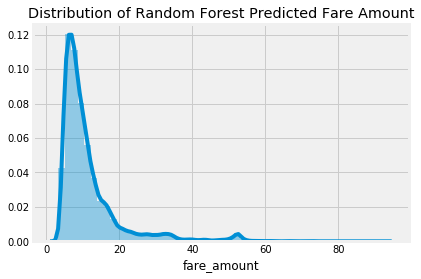

In [62]:
preds = random_forest.predict(test[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf_simple.csv', index = False)

sns.distplot(sub['fare_amount'])
plt.title('Distribution of Random Forest Predicted Fare Amount');

This time we don't see any extreme predictions as we saw with the first linear regression. The random forest tends to not produce outlying predictions because the voting of the trees means that any single tree that estimates an extreme value will be balanced by the other predictions. 

Let's look at the 3 predictions the original simple linear regression estimated as over \$100.

In [63]:
sub.loc[simple_over_100]

,key,fare_amount
4080,2010-06-11 13:37:21.0000004,13.658
5887,2010-07-04 16:44:11.0000002,6.200
8529,2009-11-25 19:32:52.0000001,5.180


Wow! The random forest and the linear regression significantly disagree. This brings up another point: one option we have for modeling is to combine the predictions of multiple models. Oftentimes, averaging the predictions of multiple models will result in better performance than either model by itself. Just for fun, let's try averaging the validation predictions of both models.

## Average Models

We'll assess the validation performance of a simple averaging of the linear regression and random forest.

In [64]:
lr_tpred = lr.predict(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])
rf_tpred = random_forest.predict(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

lr_pred = lr.predict(X_valid[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])
rf_pred = random_forest.predict(X_valid[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

# Average predictions
train_pred = (lr_tpred + rf_tpred) / 2
valid_pred = (lr_pred + rf_pred) / 2

tr, vr, tm, vm = metrics(train_pred, valid_pred, y_train, y_valid)

print(f'Combined Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Combined Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.2s finished


Combined Training:   rmse = 3.74 	 mape = 20.67
Combined Validation: rmse = 4.48 	 mape = 23.19


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.3s finished


For this problem, the random forest by itself is slightly better. However, I'd encourage you to experiment with a range of models given that the best model depends on the dataset.

# More Features

Now that we've decided on the Random Forest as our model, we can try using additional features. Let's see what happens when we use 8 of the features for training. The function below trains the random forest and assesses it on the validation data.

In [65]:
def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 20, max_depth = 20,
                                           n_jobs = -1),
             return_model = False):
    """Train and evaluate the random forest using the given set of features."""
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
    
    if return_model:
        return sub, feature_importances, model
    
    return sub, feature_importances

In [66]:
data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare-bin',
       'color', 'abs_lat_diff', 'abs_lon_diff', 'manhattan', 'euclidean',
       'haversine'],
      dtype='object')

In [67]:
# Evaluate using 8 features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

Training:   rmse = 2.5 	 mape = 16.18
Validation: rmse = 3.93 	 mape = 20.82


It appears that using more features helps the model! We can look at the feature importances to see which the model considers "most relevant".

#### Feature Importances

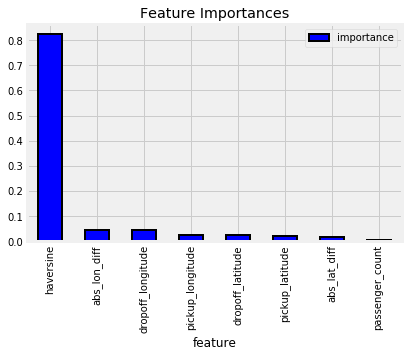

In [68]:
fi.plot.bar(color = 'b', edgecolor = 'k', linewidth = 2);
plt.title('Feature Importances');

The `haversine` distance is by far the most important with the other features showing considerably less relevance to the model. This suggests that distance is key, and we might want to find a more accurate way of calculating distances.

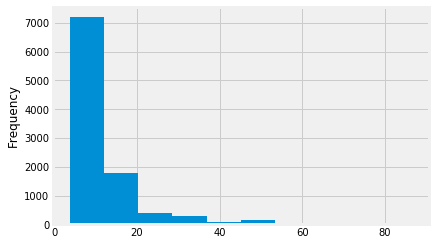

In [69]:
sub.to_csv('sub_rf_8_features.csv', index = False)
sub['fare_amount'].plot.hist();

# Additional Feature Engineering

We saw that adding more features improves the performance of the model. A natural progression is therefore to use even more features! We have not made any use of the `pickup_datetime` which provides the precise moment of pickup and that's where we'll turn our attention to next. 

## Extract Datetime Information

We can write a simple function that extracts as much date and time information from a datetime as possible. This is adapted from the excellent fast.ai library, in particular, the structured module (available at https://github.com/fastai/fastai/blob/master/fastai/structured.py). I have made a few changes based on what's worked best for me in the past on time-series problems.

This function calculates a number of expected attributes:

* Year
* Month
* Day
* Day of Year
* Day of Week

When we have a time, additional variables can be calculated:

* Hour 
* Minute 
* Second

Pandas also offers options for some more complex attributes like:

* Is_month_end  
* Is_month_start
* Is_quarter_end
* Is_quarter_start
* Is_year_end
* Is_year_start

These are more intended for financial analysis, but they may come in handy in other problems. For now, I have decided not to use these attributes. For more information on datetimes in Pandas, refer to [the documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html).

### Fractional Time Variables

Finally, I add a number of other calculations that combine existing measures to create fractional variables:

* Fractional time of day
* Fractional time of week
* Fractional time of month
* Fractional time of year

These are all measured from 0 - 1 in units of whichever time period we are measuring on. The idea behind these variables is that they can take the place of several other time indicators. For example, instead of using the `Dayof week`, `Hour`, `Minute`, and `Second`, we can use the fractional time of the week to find out precisely when the observation takes place in the week.

I have found that the fractional time variables work well in practice especially with non-linear models. When we use linear models, a good approach is [cyclical variable encoding](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/) of time features, but I haven't found this to be necessary with non-linear models. Again, you'll have to experiment with different approaches to find what works best! 

In [70]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    

    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [71]:
print(data['pickup_datetime'].min())
print(test['pickup_datetime'].min())

2009-01-01 00:31:32
2009-01-01 11:04:24


For a reference time, we can use the start of the training data. This means that the `Elapsed` measure will be the time since the beginning of the observations.

In [72]:
test = extract_dateinfo(test, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,euclidean,...,pickup_is_leap_year,pickup_Hour,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed
0,2015-01-27 13:08:24,-73.973,40.764,-73.981,40.744,1,0.020,0.008,0.028,0.022,...,False,13,8,24,365,0.547,0.221,0.861,0.075,191594212.000
1,2015-01-27 13:08:24,-73.987,40.719,-73.999,40.739,1,0.020,0.012,0.032,0.023,...,False,13,8,24,365,0.547,0.221,0.861,0.075,191594212.000
2,2011-10-08 11:53:44,-73.983,40.751,-73.980,40.746,1,0.005,0.003,0.008,0.006,...,False,11,53,44,365,0.496,0.785,0.265,0.769,87304932.000
3,2012-12-01 21:12:12,-73.981,40.768,-73.990,40.752,1,0.016,0.009,0.025,0.019,...,True,21,12,12,366,0.883,0.840,0.059,0.918,123626440.000
4,2012-12-01 21:12:12,-73.966,40.790,-73.989,40.744,1,0.045,0.023,0.068,0.051,...,True,21,12,12,366,0.883,0.840,0.059,0.918,123626440.000


In [73]:
data = extract_dateinfo(data, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,euclidean,haversine,...,pickup_Days_in_month,pickup_Hour,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed
count,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,...,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000
mean,-73.975,40.751,-73.974,40.752,1.671,0.022,0.023,0.045,0.035,3.439,...,30.469,13.467,29.548,16.611,365.145,0.582,0.491,0.534,0.531,105526352.549
std,0.043,0.034,0.039,0.035,1.279,0.026,0.037,0.056,0.042,3.977,...,0.703,6.869,18.675,19.571,0.352,0.286,0.283,0.282,0.278,55864049.590
min,-74.252,40.573,-74.263,40.569,1.000,0.000,0.000,0.000,0.000,0.000,...,28.000,0.000,0.000,0.000,365.000,0.000,0.000,0.032,0.003,37972.000
25%,-73.993,40.736,-73.991,40.735,1.000,0.007,0.006,0.017,0.013,1.300,...,30.000,8.000,13.000,0.000,365.000,0.356,0.273,0.291,0.315,59251131.000
50%,-73.982,40.753,-73.980,40.754,1.000,0.015,0.013,0.029,0.022,2.220,...,31.000,15.000,33.000,6.000,365.000,0.627,0.473,0.541,0.533,96793288.000
75%,-73.968,40.767,-73.964,40.769,2.000,0.028,0.025,0.053,0.040,4.050,...,31.000,19.000,45.000,33.000,365.000,0.827,0.727,0.805,0.758,158692575.000
max,-72.987,41.710,-72.991,41.697,6.000,0.633,0.849,1.480,1.057,100.106,...,31.000,23.000,59.000,59.000,366.000,0.999,1.000,0.999,0.999,204924738.000


## Explore Time Variables

We now have a ton of time-variables to explore! First, let's ask the question if fares have increased over time. To do this, we can plot the `time_elapsed` versus the fare.

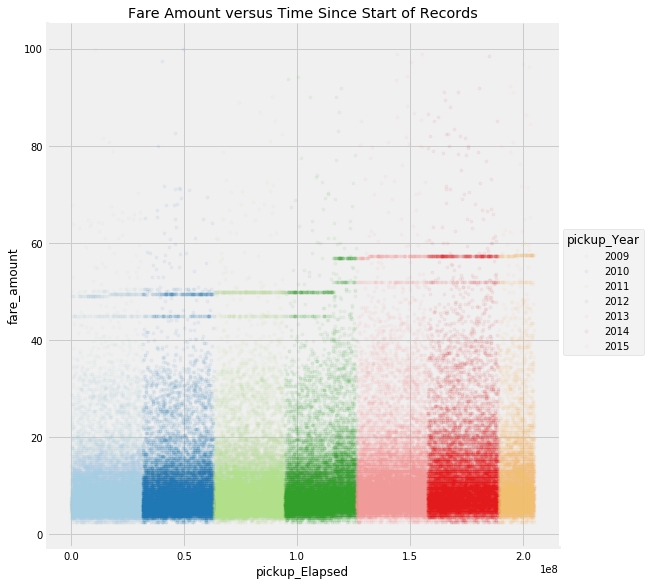

In [75]:
sns.lmplot('pickup_Elapsed', 'fare_amount', hue = 'pickup_Year', palette=palette, size = 8,
           scatter_kws= {'alpha': 0.05}, markers = '.', fit_reg = False,
           data = data.sample(100000, random_state=RSEED));
plt.title('Fare Amount versus Time Since Start of Records');

There appears to be a minor increase in prices over time which might be expected taking into account inflation. Let's look at the average fare amount by the hour of day.

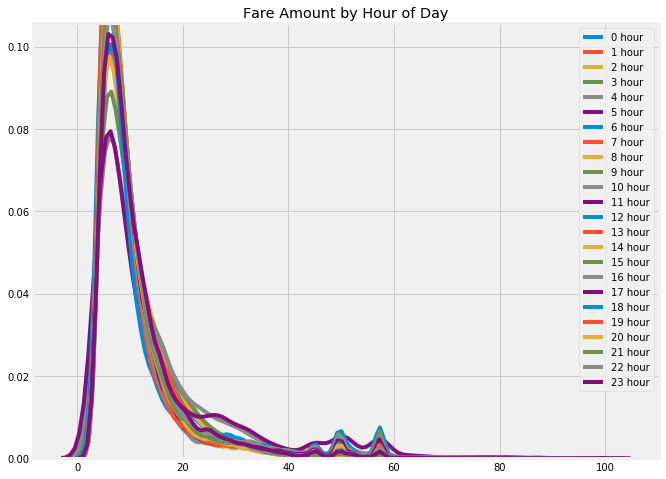

In [76]:
plt.figure(figsize = (10, 8))
for h, grouped in data.groupby('pickup_Hour'):
    sns.kdeplot(grouped['fare_amount'], label = f'{h} hour');
plt.title('Fare Amount by Hour of Day');

We can make the same plot by day of the week.

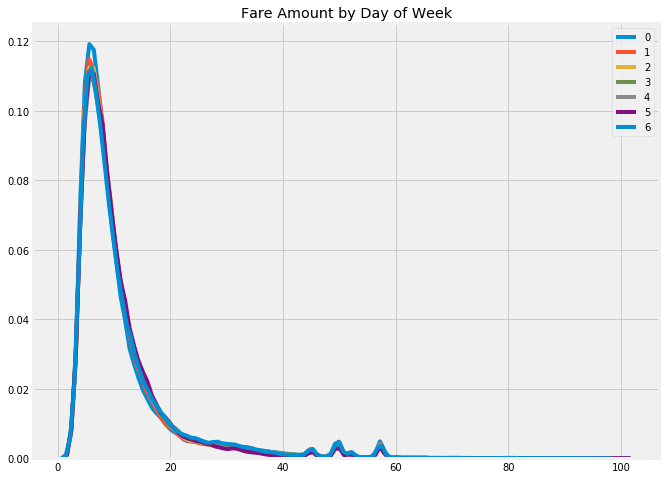

In [77]:
plt.figure(figsize = (10, 8))
for d, grouped in data.groupby('pickup_Dayofweek'):
    sns.kdeplot(grouped['fare_amount'], label = f'{d}')
plt.title('Fare Amount by Day of Week');

Both of these plots do not seem to show much difference between the different times. 

### Fractional Time Plots

As a final exploration of the time variables, we can plot the fare amount versus the fractional time. 

None of these graphs are very decisive. One interesting thing to note is the horizontal bars at different fare amounts. This suggests there may be certain routes that always have the same fare amount. We explored the fare distribution earlier, but it might be a good idea to revisit the abnormalities in the fares.

In [79]:
fare_counts = data.groupby('fare_amount')['haversine'].agg(['count', pd.Series.nunique]).sort_values('count', ascending = False)
fare_counts.head()

,count,nunique
fare_amount,,
6.500,23137,22916.000
4.500,19787,19501.000
8.500,17943,17809.000
5.300,14307,14107.000
5.700,14113,13941.000


There are a number of very common fares. These could indicate certain rides that are a set amount. It might be helpful to determine if there are standard fares, and if this information could be used for modeling. If there are set fares, the next step would be linking these to specific pickups and/or dropoffs.

#### Correlations with Target

Again we can show the correlations of all features with the target. 

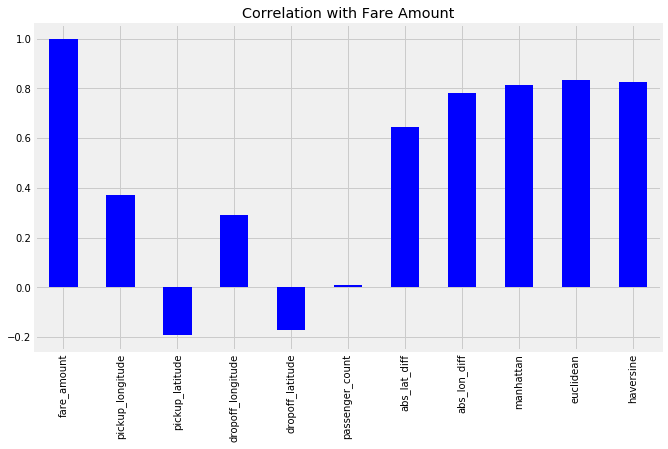

In [80]:
# corrs = data.corr()
corrs['fare_amount'].plot.bar(color = 'b', figsize = (10, 6));
plt.title('Correlation with Fare Amount');

It seems the most useful time variables may be the `Year` or `Elapsed` because most of the time features have a small correlation with the target. The `Elapsed` correlation is positive indicating that fares have tended to increase over time.

### Test Time Features

Now we can use the time features in our model to see if they yield any improvement. We'll need to resplit the data (using the same random state).

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 100000)

For the time features, we'll use the fractional measurements for the day, week, and year, as well as the time elapsed since the beginning of the records. We'll keep the other same features as the previous training run. (This gives us a total of 12 features).

In [83]:
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_year', 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features

In [84]:
# Test using the features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = features)

Training:   rmse = 2.1 	 mape = 13.34
Validation: rmse = 3.59 	 mape = 18.29


The random forest does considerably better once we use the time features! As with the distance features, this should give us confidence that the new predictor variables we built are useful.

Just for comparison, we can go back to the linear regression and look at the performance.

In [85]:
lr = LinearRegression()

# Fit and evaluate
lr.fit(X_train[features], y_train)
evaluate(lr, features, X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.88 	 mape = 24.07
Validation: rmse = 4.92 	 mape = 24.08


It seems that the new features helped both the random forest and the linear regression. Let's take a look at the random forest feature importances.

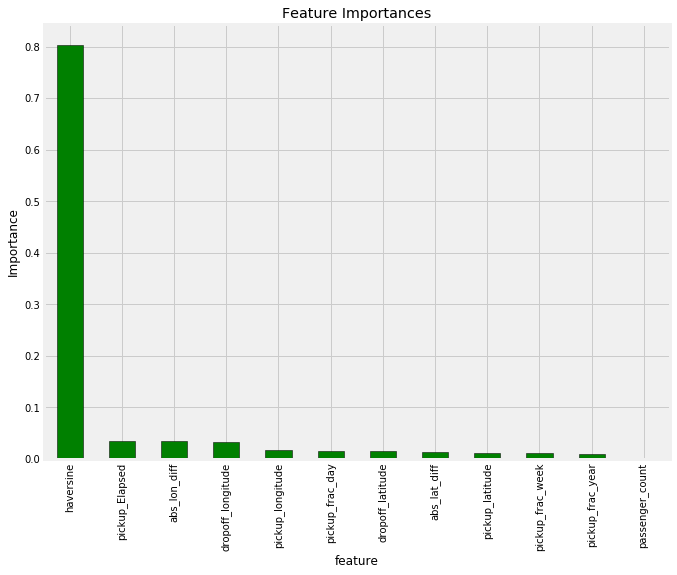

In [86]:
plt.figure(figsize = (10, 8))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); plt.title('Feature Importances');

Once again, the `haversine` distance dominates the importance. The time elapsed since the first record seems to be relatively important although the other time features do not seem to be of much use. 

In [87]:
# Save submission
sub.to_csv('sub_rf_frac_time.csv', index = False)

## Try with All Time Variables

For a final submission with the random forest, we'll use every single one of the features. This probably will lead to overfitting, but let's test it out.

In [88]:
features = list(data.columns)

for f in ['pickup_datetime', 'fare_amount', 'fare-bin', 'color']:
    features.remove(f)
    
len(features)

27

In [89]:
# Test using all the features
sub, fi, random_forest = model_rf(X_train, X_valid, y_train, y_valid, test, 
                                  features = features, return_model = True)

Training:   rmse = 2.08 	 mape = 13.51
Validation: rmse = 3.6 	 mape = 18.48


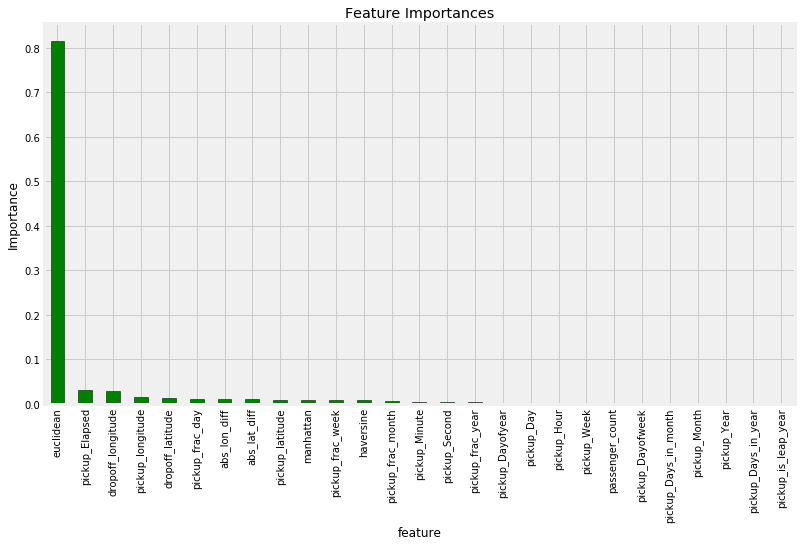

In [90]:
plt.figure(figsize = (12, 7))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); plt.title('Feature Importances');

In [91]:
sub.to_csv('sub_rf_all_features.csv', index = False)

#### Visualize Validation Predicted Target

Using the trained random forest, we can make predictions on the validation set and plot the predictions versus the actual. This can allow us to potentially diagnose the model.

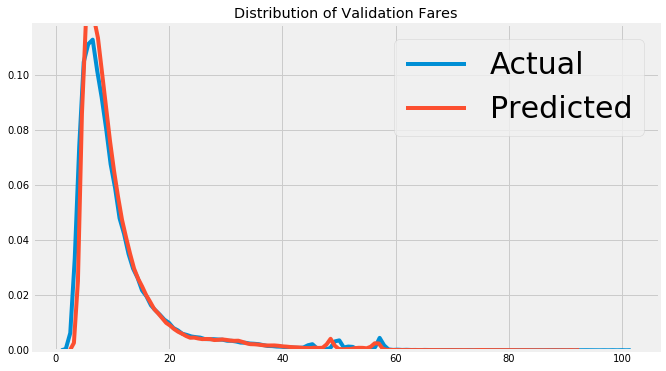

In [92]:
valid_preds = random_forest.predict(X_valid[features])

plt.figure(figsize = (10, 6))
sns.kdeplot(y_valid, label = 'Actual')
sns.kdeplot(valid_preds, label = 'Predicted')
plt.legend(prop = {'size': 30})
plt.title("Distribution of Validation Fares");

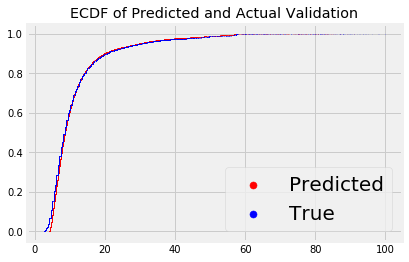

In [93]:
# Generate ecdf data
xv, yv = ecdf(valid_preds)
xtrue, ytrue = ecdf(y_valid)

# Plot the ecdfs on same plot
plt.scatter(xv, yv, s = 0.02,  c = 'r', marker = '.', label = 'Predicted')
plt.scatter(xtrue, ytrue, s = 0.02, c = 'b', marker = '.', label = 'True')
plt.title('ECDF of Predicted and Actual Validation')

plt.legend(markerscale = 100, prop = {'size': 20});

In [94]:
analyze = pd.DataFrame({'predicted': valid_preds, 'actual': y_valid})
analyze.describe()

,predicted,actual
count,100000.000,100000.000
mean,11.345,11.277
std,8.760,9.379
min,3.952,2.500
25%,6.342,6.000
50%,8.577,8.500
75%,12.551,12.500
max,90.971,100.000


At this point, our model is probably overfitting because we are using all the features, some of which are highly correlated with one another. One option for feature selection is to use only the most important features from the model. 

# Hyperparameter Tuning

With the random forest, there are a ton of model hyperparamters to optimize. The process of hyperparameter optimization means finding the best hyperparameters for an algorithm on a specific dataset. The ideal values changes across data sets so we have to perform this step on every new dataset. I like to think of hyperparameter optimization as finding the best settings for a machine learning model.

### Random Search

We'll use a basic form of hyperparameter tuning, random search. This means constructing a parameter grid and then randomly selecting combinations of values, evaluating them in cross validation, and determining which combination performs the best. This is quickly done using the `RandomizedSearchCV` in Scikit-Learn.

The following code sets up the search. Feel free to play around with the `param_grid`.

In [95]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 100).astype(int),
    'max_depth': [None] + list(np.linspace(5, 30).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestRegressor(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'neg_mean_absolute_error', cv = 3, 
                        n_iter = 100, verbose = 1, random_state=RSEED)

We'll use a very limited sample of the data since random search is computationally expensive. Random search uses K Fold cross validation to assess the model which means that for each combination of hyperparameters, we are training and testing the model K times, in this example 3. This is another option that can be adjusted to determine if performance is affected.

In [96]:
tune_data = data.sample(100_000, random_state = RSEED)

# Select features
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_year', 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features

rs.fit(tune_data[features], np.array(tune_data['fare_amount']))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.6min


KeyboardInterrupt: 

In [ ]:
model = rs.best_estimator_
print(f'The best parameters were {rs.best_params_} with a negative mae of {rs.best_score_}')

#### Evaluate Best Model from Random Search

The best model from random search is available through the `best_estimator_` attribute of the fitted random search object. Random search refits the best estimator on all the data we give it, but since this was only a sample of the full data, we have to use the entire dataset for retraining.

In [ ]:
model.n_jobs = -1
model.fit(X_train[features], y_train)

evaluate(model, features, X_train, X_valid, y_train, y_valid)

The best model from random search exhibits less overfitting, but also does not do as well on the validation data. There are probably further benefits from more hyperparameter tuning using additional data. 

In [ ]:
pred = np.array(model.predict(test[features])).reshape((-1))
sub = pd.DataFrame({'key': test_id, 'fare_amount': pred})
sub.to_csv('sub_rf_tuned.csv', index = False)
sub['fare_amount'].plot.hist();
plt.title('Predicted Test Fare Distribution');

## Better Model

Although the random forest has high performance, it does not always work the best for every problem. There are still more [models to try](http://scikit-learn.org/stable/supervised_learning.html):

* __Potential improvement 5: try more models.__ You might find the Gradient Boosting Machine or Deep Neural Networks to be capable learners.

# Your Challenge

From here, we can still engineer more features, perform feature selection, or we can try upgrading the model. At this point, I'm going to leave it up to you! I've given you a decent start and some recommendations for improvement so I'll hand things over to you. __Try to build a model that outperforms those in this notebook on the validation data.__

The best performance of the models is as follows:

| Model         | Train RMSE | Validation RMSE |
|---------------|------------|-----------------|
| Linear        | 4.87       | 4.86            |
| Random Forest | 2.62       | 3.38            |

It's important to try and beat the __validation score__ as opposed to the training score because you can always get a better training score by training a model with greater capacity (more flexibility to fit the data). However, this won't improve the generalization performance, which is the goal of machine learning: build a model that generalizes to new data! You can also submit the predictions from this notebook and try to better the testing predictions. I look forward to seeing what you can come up with.

I'm working on some more notebooks with additional performance gains, but see if you can take these methods and improve! To wrap up, here are my recommendations:

1. Train with more data
2. Experiment with different methods for filtering outliers
3. Find an optimal set of features or build more features
4. Hyperparameter tuning of the random forest
5. Try more complex models such as the gradient boosting machine

I have to add that these are all __potential__ improvements because of course we don't know if they will work until we try! I wish you the best of luck, and I'll be back in another kernel trying some improvements of my own. 

Best,

Will